In [1]:
import gym
import numpy as np
import random
from timeit import default_timer as timer
from datetime import timedelta
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns

from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv

np.random.seed(2023)

In [2]:
def get_avg_reward(env, policy, n_epoch=1000):
    rewards = []
    episode_counts = []
    for i in range(n_epoch):
        current_state = env.reset()
        ep = 0
        done = False
        episode_reward = 0
        while not done and ep < n_epoch:
            ep += 1
            act = int(policy[current_state])
            state_next, reward, done, _ = env.step(act)
            episode_reward += reward
            current_state = state_next

        rewards.append(episode_reward)
        episode_counts.append(ep)
        
    return sum(rewards)/len(rewards), sum(episode_counts)/len(episode_counts)


def value_iteration(env, discount=0.9, epsilon=1e-12):
    start = timer()
    
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    
    policy = np.zeros((1, num_states))
    values = np.zeros((1, num_states))
    old_values = values.copy()
    
    episode = 0
    max_change = 1
    while max_change > epsilon:
        episode += 1
        for s in range(num_states):
            value_temp = -np.inf
            for a in range(num_actions):      
                total_value = 0
                for prob, new_state, reward, done in env.P[s][a]:
                    val = old_values[0][new_state]
                    cand_value = 0
                    if done:
                        cand_value = reward 
                    else:
                        cand_value = reward + discount*val
                    total_value += cand_value*prob 
                        
                if total_value > value_temp:
                    value_temp = total_value
                    policy[0][s] = a
                    values[0][s] = value_temp
        changes = np.abs(values - old_values)
        max_change = np.max(changes)
        old_values = values.copy()
        
    end = timer()
    time_spent = timedelta(seconds=end-start)
    return policy[0], episode, time_spent

In [3]:
def policy_iteration(env, discount=0.9, epsilon=1e-3):
    
    start = timer()
    
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    policy = np.random.randint(num_actions, size=(1,num_states))
    values = np.zeros((1, num_states))
    episode = 0

    policy_stable = False
    while not policy_stable:
        episode += 1
        eval_acc = True
        while eval_acc:
            eps = 0
            for s in range(num_states):
                v = values[0][s]
                a = policy[0][s]
                total_val = 0
                for prob, new_state, reward, done in env.P[s][a]:
                    val = values[0][new_state]
                    val_temp = 0
                    if done:
                        val_temp = reward                     
                    else:
                        val_temp = reward + discount*val
                    total_val += val_temp*prob 
                values[0][s] = total_val
                eps = max(eps, np.abs(v-values[0][s]))
            if eps < epsilon:
                eval_acc = False

        policy_stable = True
        for s in range(num_states):
            old_action = policy[0][s]
            max_value = -np.inf
            for a in range(num_actions):
                total_value = 0
                for prob, new_state, reward, done in env.P[s][a]:
                    val = values[0][new_state]
                    val_temp = 0
                    if done:
                        val_temp = reward
                    else:
                        val_temp = reward + discount*val
                    total_value += prob*val_temp
                if total_value > max_value:
                    max_value = total_value
                    policy[0][s] = a

            if old_action != policy[0][s]:
                policy_stable = False
    
    end = timer()
    time_spent = timedelta(seconds=end-start)
    return policy[0], episode, time_spent
        

In [4]:
def q_learning(env, discount=0.9, n_iter=1e4, alpha=0.1, decay_rate=None,
               min_epsilon=0.01):
    
    start = timer()
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    
    Q = np.zeros((num_states, num_actions))
    learning_rate = alpha
    epsilon = 1.0
    max_epsilon = 1.0
    min_epsilon = 0.01
    
    if not decay_rate:
        decay_rate = 1./n_iter
    
    rewards = []
    for episode in range(int(n_iter)):
        state = env.reset()
        step = 0
        done = False
        total_reward = 0
        while True:
            if random.uniform(0,1) > epsilon:
                b = Q[state, :]
                action = np.random.choice(np.where(b == b.max())[0])
            else:
                action = env.action_space.sample()
            new_state, reward, done, info = env.step(action)
            total_reward += reward
            if not done:
                Q[state, action] = Q[state, action] + learning_rate*(reward + discount*np.max(Q[new_state, :]) - Q[state, action])
            else:
                Q[state, action] = Q[state,action] + learning_rate*(reward - Q[state,action])

            state = new_state
            if done:
                break

        rewards.append(total_reward)
        epsilon = max(max_epsilon -  decay_rate * episode, min_epsilon)
    
    end = timer()
    time_spent = timedelta(seconds=end-start)
    return np.argmax(Q, axis=1), n_iter, time_spent, Q, rewards

In [5]:
def run_pi_vi(env, discount=None, epsilon=None, mute=False):
    if discount is None:
        discount=[0.9]
    if epsilon is None:
        epsilon=[1e-9]
    
    # run value iteration
    vi_dict = {}
    for dis in discount:
        vi_dict[dis] = {}
        for eps in epsilon:
            vi_dict[dis][eps] = {}
            vi_policy, vi_solve_iter, vi_solve_time = value_iteration(env, dis, eps)
            vi_mrews, vi_meps = get_avg_reward(env, vi_policy)    
            vi_dict[dis][eps]["mean_reward"] = vi_mrews
            vi_dict[dis][eps]["mean_eps"] = vi_meps
            vi_dict[dis][eps]["iteration"] = vi_solve_iter
            vi_dict[dis][eps]["time_spent"] = vi_solve_time
            vi_dict[dis][eps]["policy"] = vi_policy
            if not mute:
                print("Finished: Value iteration for {} discount and {} eps".format(dis, eps))
    
    # run policy iteration
    pi_dict = {}
    for dis in discount:
        pi_dict[dis] = {}
        for eps in epsilon:
            pi_dict[dis][eps] = {}
            pi_policy, pi_solve_iter, pi_solve_time = policy_iteration(env, dis, eps)
            pi_mrews, pi_meps = get_avg_reward(env, pi_policy)    
            pi_dict[dis][eps]["mean_reward"] = pi_mrews
            pi_dict[dis][eps]["mean_eps"] = pi_meps
            pi_dict[dis][eps]["iteration"] = pi_solve_iter
            pi_dict[dis][eps]["time_spent"] = pi_solve_time
            pi_dict[dis][eps]["policy"] = pi_policy
            if not mute:
                print("Finished: Policy iteration for {} discount".format(dis))

    return vi_dict, pi_dict


def run_qlearning(env, discount=None, n_iter=None, alphas=None, decay_rates=None, mute=False):
    
    min_epsilon = 0.01
    
    if discount is None:
        discount=[0.9]
    if n_iter is None:
        n_iter=[1e5]
    if alphas is None:
        alphas = [0.1]
    if decay_rates is None:
        decay_rates=[0.01]
    
    
    q_dict = {}
    for dis in discount:
        q_dict[dis] = {}
        for eps in n_iter:
            q_dict[dis][eps] = {}
            for alpha in alphas:
                q_dict[dis][eps][alpha] = {}
                for dr in decay_rates:
                    q_dict[dis][eps][alpha][dr] = {}
                    
                    q_policy, q_solve_iter, q_solve_time, q_table, rewards = q_learning(env, dis, eps, alpha, dr, min_epsilon)
                    q_mrews, q_meps= get_avg_reward(env, q_policy)
                    q_dict[dis][eps][alpha][dr]["mean_reward"] = q_mrews
                    q_dict[dis][eps][alpha][dr]["mean_eps"] = q_meps
                    q_dict[dis][eps][alpha][dr]["q-table"] = q_table
                    q_dict[dis][eps][alpha][dr]["rewards"] = rewards 
                    q_dict[dis][eps][alpha][dr]["iteration"] = q_solve_iter
                    q_dict[dis][eps][alpha][dr]["time_spent"] = q_solve_time
                    q_dict[dis][eps][alpha][dr]["policy"] = q_policy
                    if not mute:
                        print("Finished: discount: {} total_eps: {} lr: {}, dr: {}".format(dis, eps, alpha, dr))
    return q_dict

## visualization

In [6]:
def map_discretize(map0):
    size = len(map0)
    map1 = np.zeros((size,size))
    for i, row in enumerate(map0):
        for j, loc in enumerate(row):
            if loc == "S":
                map1[i, j] = 0
            elif loc == "F":
                map1[i, j] = 0
            elif loc == "H":
                map1[i, j] = -1
            elif loc == "G":
                map1[i, j] = 1
    return map1


def policy_np(policy):
    size = int(np.sqrt(len(policy)))
    pol = np.asarray(policy)
    pol = pol.reshape((size, size))
    return pol


def see_policy(map_lake, policy):
    data = map_discretize(map_lake)
    np_pol = policy_np(policy)
    plt.figure(figsize=(8,6))
    plt.imshow(data, interpolation="nearest")

    for i in range(np_pol[0].size):
        for j in range(np_pol[0].size):
            arrow = '\u2190'
            if np_pol[i, j] == 1:
                arrow = '\u2193'
            elif np_pol[i, j] == 2:
                arrow = '\u2192'
            elif np_pol[i, j] == 3:
                arrow = '\u2191'
            text = plt.text(j, i, arrow,
                           ha="center", va="center", color="w")
    plt.show()

    
def smoothed_cumsum(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [7]:
map_lake = generate_random_map(8)
env = FrozenLakeEnv(desc=map_lake)

# Value Iteration and Policy Iteration

In [8]:
vi_dict, pi_dict = run_pi_vi(env, discount=[0.5, 0.75, 0.9, 0.95, 0.99, 0.9999], 
                                        epsilon=[1e-3, 1e-6, 1e-9, 1e-12], mute=False)

Finished: Value iteration for 0.5 discount and 0.001 eps
Finished: Value iteration for 0.5 discount and 1e-06 eps
Finished: Value iteration for 0.5 discount and 1e-09 eps
Finished: Value iteration for 0.5 discount and 1e-12 eps
Finished: Value iteration for 0.75 discount and 0.001 eps
Finished: Value iteration for 0.75 discount and 1e-06 eps
Finished: Value iteration for 0.75 discount and 1e-09 eps
Finished: Value iteration for 0.75 discount and 1e-12 eps
Finished: Value iteration for 0.9 discount and 0.001 eps
Finished: Value iteration for 0.9 discount and 1e-06 eps
Finished: Value iteration for 0.9 discount and 1e-09 eps
Finished: Value iteration for 0.9 discount and 1e-12 eps
Finished: Value iteration for 0.95 discount and 0.001 eps
Finished: Value iteration for 0.95 discount and 1e-06 eps
Finished: Value iteration for 0.95 discount and 1e-09 eps
Finished: Value iteration for 0.95 discount and 1e-12 eps
Finished: Value iteration for 0.99 discount and 0.001 eps
Finished: Value iterat

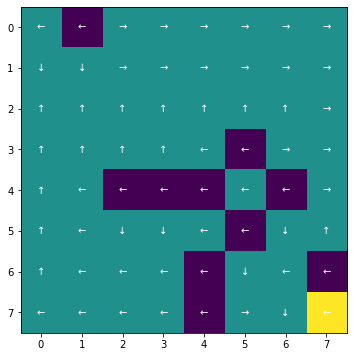

In [9]:
pol = vi_dict[0.99][1e-12]['policy']
see_policy(map_lake, pol)

In [10]:
vi_df = pd.DataFrame.from_dict({(i,j): vi_dict[i][j] 
                           for i in vi_dict.keys() 
                           for j in vi_dict[i].keys()},
                       orient='index')
vi_df

mean_reward  mean_eps  iteration             time_spent  \
0.5000 1.000000e-03        0.000  1000.000          7 0 days 00:00:00.004926   
       1.000000e-06        0.121    71.838         15 0 days 00:00:00.006930   
       1.000000e-09        0.108    61.357         23 0 days 00:00:00.011579   
       1.000000e-12        0.086    60.949         33 0 days 00:00:00.014449   
0.7500 1.000000e-03        0.000  1000.000         11 0 days 00:00:00.004618   
       1.000000e-06        0.123    61.175         29 0 days 00:00:00.013351   
       1.000000e-09        0.101    61.118         52 0 days 00:00:00.023624   
       1.000000e-12        0.094    62.923         75 0 days 00:00:00.033335   
0.9000 1.000000e-03        0.103    62.047         17 0 days 00:00:00.007887   
       1.000000e-06        0.134    66.111         72 0 days 00:00:00.032532   
       1.000000e-09        0.119    65.478        127 0 days 00:00:00.056885   
       1.000000e-12        0.110    64.129        177 0 days 00:00:00.081889   
0.9500 1.000000e-03        0.115    61.188         24 0 days 00:00:00.011065   
       1.000000e-06        0.151    79.729        132 0 days 00:00:00.058985   
       1.000000e-09        0.147    79.774        226 0 days 00:00:00.101706   
       1.000000e-12        0.132    78.771        320 0 days 00:00:00.143395   
0.9900 1.000000e-03        0.193   108.398         68 0 days 00:00:00.030782   
       1.000000e-06        0.226   111.494        356 0 days 00:00:00.159198   
       1.000000e-09        0.224   114.508        619 0 days 00:00:00.284236   
       1.000000e-12        0.230   109.762        882 0 days 00:00:00.399535   
0.9999 1.000000e-03        0.243   115.395        147 0 days 00:00:00.072734   
       1.000000e-06        0.199   108.502        579 0 days 00:00:00.272150   
       1.000000e-09        0.226   111.875       1002 0 days 00:00:00.461262   
       1.000000e-12        0.213   108.328       1425 0 days 00:00:00.643573   

                                                                policy  
0.5000 1.000000e-03  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
       1.000000e-06  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
       1.000000e-09  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
       1.000000e-12  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
0.7500 1.000000e-03  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, ...  
       1.000000e-06  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
       1.000000e-09  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
       1.000000e-12  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
0.9000 1.000000e-03  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
       1.000000e-06  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
       1.000000e-09  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
       1.000000e-12  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
0.9500 1.000000e-03  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
       1.000000e-06  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
       1.000000e-09  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
       1.000000e-12  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
0.9900 1.000000e-03  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
       1.000000e-06  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
       1.000000e-09  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
       1.000000e-12  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
0.9999 1.000000e-03  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
       1.000000e-06  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
       1.000000e-09  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...  
       1.000000e-12  [0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ...

In [53]:
cols1 = ['gamma', 'epsilon'] + vi_df.columns.tolist()
vi_df_1 = vi_df.reset_index()
vi_df_1.columns = cols1
vi_df_1['time_spent'] = vi_df_1['time_spent'].apply(lambda x: x.total_seconds())
vi_df_1


,gamma,epsilon,mean_reward,mean_eps,iteration,time_spent,policy
0,0.5000,1.000000e-03,0.000,1000.000,7,0.004926,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0.5000,1.000000e-06,0.121,71.838,15,0.006930,"[0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ..."
2,0.5000,1.000000e-09,0.108,61.357,23,0.011579,"[0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ..."
3,0.5000,1.000000e-12,0.086,60.949,33,0.014449,"[0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ..."
4,0.7500,1.000000e-03,0.000,1000.000,11,0.004618,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, ..."
5,0.7500,1.000000e-06,0.123,61.175,29,0.013351,"[0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ..."
6,0.7500,1.000000e-09,0.101,61.118,52,0.023624,"[0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ..."
7,0.7500,1.000000e-12,0.094,62.923,75,0.033335,"[0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ..."
8,0.9000,1.000000e-03,0.103,62.047,17,0.007887,"[0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ..."
9,0.9000,1.000000e-06,0.134,66.111,72,0.032532,"[0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, ..."


In [54]:
vi_df_1[['gamma', 'mean_reward', 'mean_eps','iteration','time_spent']].groupby('gamma').mean()

,mean_reward,mean_eps,iteration,time_spent
gamma,,,,
0.5000,0.07875,298.53600,19.50,0.009471
0.7500,0.07950,296.30400,41.75,0.018732
0.9000,0.11650,64.44125,98.25,0.044798
0.9500,0.13625,74.86550,175.50,0.078788
0.9900,0.21825,111.04050,481.25,0.218438
0.9999,0.22025,111.02500,788.25,0.362430


In [55]:
vi_df_1[['epsilon', 'mean_reward', 'mean_eps','iteration','time_spent']].groupby('epsilon').mean()

,mean_reward,mean_eps,iteration,time_spent
epsilon,,,,
1.000000e-12,0.144167,80.810333,485.333333,0.219363
1.000000e-09,0.154167,82.351667,341.500000,0.156549
1.000000e-06,0.159000,83.141500,197.166667,0.090524
1.000000e-03,0.109000,391.171333,45.666667,0.022002


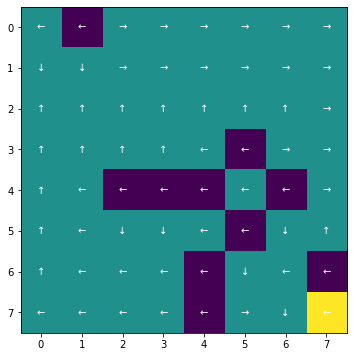

In [18]:
pol1 = pi_dict[0.99][1e-12]['policy']
see_policy(map_lake, pol1)

In [14]:
pi_df = pd.DataFrame.from_dict({(i,j): pi_dict[i][j] 
                           for i in pi_dict.keys() 
                           for j in pi_dict[i].keys()},
                       orient='index')
pi_df

mean_reward  mean_eps  iteration             time_spent  \
0.5000 1.000000e-03        0.104    60.238         12 0 days 00:00:00.010536   
       1.000000e-06        0.099    61.559         11 0 days 00:00:00.013348   
       1.000000e-09        0.110    63.033         11 0 days 00:00:00.023214   
       1.000000e-12        0.116    61.660         14 0 days 00:00:00.042779   
0.7500 1.000000e-03        0.117    61.294         13 0 days 00:00:00.013190   
       1.000000e-06        0.102    61.058         11 0 days 00:00:00.028523   
       1.000000e-09        0.112    60.839         11 0 days 00:00:00.056760   
       1.000000e-12        0.103    59.925         11 0 days 00:00:00.085520   
0.9000 1.000000e-03        0.130    61.922         16 0 days 00:00:00.021255   
       1.000000e-06        0.116    65.633         12 0 days 00:00:00.062948   
       1.000000e-09        0.120    65.806          4 0 days 00:00:00.068841   
       1.000000e-12        0.136    66.704          4 0 days 00:00:00.112054   
0.9500 1.000000e-03        0.151    81.876         11 0 days 00:00:00.022867   
       1.000000e-06        0.163    79.783          4 0 days 00:00:00.066639   
       1.000000e-09        0.166    76.628         11 0 days 00:00:00.190336   
       1.000000e-12        0.155    79.017          3 0 days 00:00:00.136827   
0.9900 1.000000e-03        0.220   112.373         13 0 days 00:00:00.048860   
       1.000000e-06        0.241   111.860         12 0 days 00:00:00.254826   
       1.000000e-09        0.210   111.715          8 0 days 00:00:00.407609   
       1.000000e-12        0.206   107.543         12 0 days 00:00:00.478037   
0.9999 1.000000e-03        0.222   115.327          5 0 days 00:00:00.052527   
       1.000000e-06        0.232   112.401          4 0 days 00:00:00.186364   
       1.000000e-09        0.218   111.053         12 0 days 00:00:00.497934   
       1.000000e-12        0.211   112.924         12 0 days 00:00:00.705988   

                                                                policy  
0.5000 1.000000e-03  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
       1.000000e-06  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
       1.000000e-09  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
       1.000000e-12  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
0.7500 1.000000e-03  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
       1.000000e-06  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
       1.000000e-09  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
       1.000000e-12  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
0.9000 1.000000e-03  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
       1.000000e-06  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
       1.000000e-09  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
       1.000000e-12  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
0.9500 1.000000e-03  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
       1.000000e-06  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
       1.000000e-09  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
       1.000000e-12  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
0.9900 1.000000e-03  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
       1.000000e-06  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
       1.000000e-09  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
       1.000000e-12  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
0.9999 1.000000e-03  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
       1.000000e-06  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
       1.000000e-09  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
       1.000000e-12  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...

In [50]:
cols2 = ['gamma', 'epsilon'] + pi_df.columns.tolist()
pi_df_1 = pi_df.reset_index()
pi_df_1.columns = cols2
pi_df_1['time_spent'] = pi_df_1['time_spent'].apply(lambda x: x.total_seconds())
pi_df_1


,gamma,epsilon,mean_reward,mean_eps,iteration,time_spent,policy
0,0.5000,1.000000e-03,0.104,60.238,12,0.010536,"[0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ..."
1,0.5000,1.000000e-06,0.099,61.559,11,0.013348,"[0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ..."
2,0.5000,1.000000e-09,0.110,63.033,11,0.023214,"[0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ..."
3,0.5000,1.000000e-12,0.116,61.660,14,0.042779,"[0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ..."
4,0.7500,1.000000e-03,0.117,61.294,13,0.013190,"[0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ..."
5,0.7500,1.000000e-06,0.102,61.058,11,0.028523,"[0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ..."
6,0.7500,1.000000e-09,0.112,60.839,11,0.056760,"[0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ..."
7,0.7500,1.000000e-12,0.103,59.925,11,0.085520,"[0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ..."
8,0.9000,1.000000e-03,0.130,61.922,16,0.021255,"[0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ..."
9,0.9000,1.000000e-06,0.116,65.633,12,0.062948,"[0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ..."


In [51]:
pi_df_1[['gamma', 'mean_reward', 'mean_eps','iteration', 'time_spent']].groupby('gamma').mean()

,mean_reward,mean_eps,iteration,time_spent
gamma,,,,
0.5000,0.10725,61.62250,12.00,0.022469
0.7500,0.10850,60.77900,11.50,0.045998
0.9000,0.12550,65.01625,9.00,0.066275
0.9500,0.15875,79.32600,7.25,0.104167
0.9900,0.21925,110.87275,11.25,0.297333
0.9999,0.22075,112.92625,8.25,0.360703


In [52]:
pi_df_1[['epsilon', 'mean_reward', 'mean_eps','iteration','time_spent']].groupby('epsilon').mean()

,mean_reward,mean_eps,iteration,time_spent
epsilon,,,,
1.000000e-12,0.154500,81.295500,9.333333,0.260201
1.000000e-09,0.156000,81.512333,9.500000,0.207449
1.000000e-06,0.158833,82.049000,9.000000,0.102108
1.000000e-03,0.157333,82.171667,11.666667,0.028206


# Q Learning

In [8]:
q_dict = run_qlearning(env, discount=[0.75, 0.9, 0.99], n_iter=[1e5, 1e6],
                          alphas=[0.01, 0.1], decay_rates=[1e-6])

Finished: discount: 0.75 total_eps: 100000.0 lr: 0.01, dr: 1e-06
Finished: discount: 0.75 total_eps: 100000.0 lr: 0.1, dr: 1e-06
Finished: discount: 0.75 total_eps: 1000000.0 lr: 0.01, dr: 1e-06
Finished: discount: 0.75 total_eps: 1000000.0 lr: 0.1, dr: 1e-06
Finished: discount: 0.9 total_eps: 100000.0 lr: 0.01, dr: 1e-06
Finished: discount: 0.9 total_eps: 100000.0 lr: 0.1, dr: 1e-06
Finished: discount: 0.9 total_eps: 1000000.0 lr: 0.01, dr: 1e-06
Finished: discount: 0.9 total_eps: 1000000.0 lr: 0.1, dr: 1e-06
Finished: discount: 0.99 total_eps: 100000.0 lr: 0.01, dr: 1e-06
Finished: discount: 0.99 total_eps: 100000.0 lr: 0.1, dr: 1e-06
Finished: discount: 0.99 total_eps: 1000000.0 lr: 0.01, dr: 1e-06
Finished: discount: 0.99 total_eps: 1000000.0 lr: 0.1, dr: 1e-06


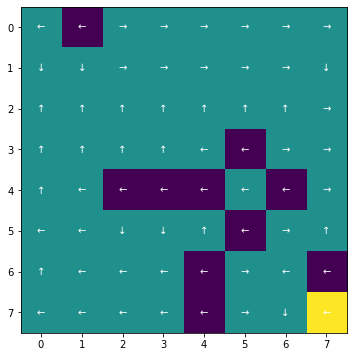

In [17]:
pol2 = q_dict[0.99][1e6][0.01][1e-6]['policy']
see_policy(map_lake, pol2)

In [11]:
q_df = pd.DataFrame.from_dict({(i,j, k): q_dict[i][j][k][1e-6] 
                           for i in q_dict.keys() 
                           for j in q_dict[i].keys()
                            for k in q_dict[i][j].keys()},
                       orient='index')
q_df

mean_reward  mean_eps  \
0.75 100000.0  0.01        0.047    60.429   
               0.10        0.009    51.696   
     1000000.0 0.01        0.050    46.336   
               0.10        0.014    44.967   
0.90 100000.0  0.01        0.000  1000.000   
               0.10        0.070    80.581   
     1000000.0 0.01        0.161    81.579   
               0.10        0.140    78.169   
0.99 100000.0  0.01        0.020    54.064   
               0.10        0.105   102.157   
     1000000.0 0.01        0.232   114.921   
               0.10        0.173   164.553   

                                                               q-table  \
0.75 100000.0  0.01  [[2.3287985666909375e-12, 1.7615615738330537e-...   
               0.10  [[6.061672939919264e-07, 4.3968685366016187e-0...   
     1000000.0 0.01  [[1.2099685600144918e-06, 9.613192445607883e-0...   
               0.10  [[1.1247050734314323e-06, 5.180905937735475e-0...   
0.90 100000.0  0.01  [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...   
               0.10  [[1.1308720134078379e-05, 9.53507093208826e-06...   
     1000000.0 0.01  [[0.0005112465627080456, 0.0003442435301664455...   
               0.10  [[0.00047389554377892695, 0.000169465032299416...   
0.99 100000.0  0.01  [[1.6884128098918264e-09, 1.1510553980589842e-...   
               0.10  [[0.010206734677775666, 0.006294883874328933, ...   
     1000000.0 0.01  [[0.08242536399678428, 0.05400649419884493, 0....   
               0.10  [[0.06980787795479729, 0.06291625625802896, 0....   

                                                               rewards  \
0.75 100000.0  0.01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
               0.10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
     1000000.0 0.01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
               0.10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0.90 100000.0  0.01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
               0.10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
     1000000.0 0.01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
               0.10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0.99 100000.0  0.01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
               0.10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
     1000000.0 0.01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
               0.10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                     iteration             time_spent  \
0.75 100000.0  0.01   100000.0 0 days 00:00:23.632020   
               0.10   100000.0 0 days 00:00:23.039896   
     1000000.0 0.01  1000000.0 0 days 00:14:39.880164   
               0.10  1000000.0 0 days 00:11:56.300311   
0.90 100000.0  0.01   100000.0 0 days 00:00:22.091389   
               0.10   100000.0 0 days 00:00:22.514121   
     1000000.0 0.01  1000000.0 0 days 00:16:28.608248   
               0.10  1000000.0 0 days 00:15:45.616279   
0.99 100000.0  0.01   100000.0 0 days 00:00:25.598123   
               0.10   100000.0 0 days 00:00:23.206297   
     1000000.0 0.01  1000000.0 0 days 00:22:52.289740   
               0.10  1000000.0 0 days 00:23:13.262511   

                                                                policy  
0.75 100000.0  0.01  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, ...  
               0.10  [0, 0, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
     1000000.0 0.01  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, ...  
               0.10  [0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 2, 3, 1, 2, 1, ...  
0.90 100000.0  0.01  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
               0.10  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 3, 2, 2, ...  
     1000000.0 0.01  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
               0.10  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 3, 2, 2, ...  
0.99 100000.0  0.01  [0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ...  
               0.10  [0,

In [12]:
cols3 = ['gamma', 'n_iter', 'lr'] + q_df.columns.tolist()
q_df_1 = q_df.reset_index()
q_df_1.columns = cols3
q_df_1['time_spent'] = q_df_1['time_spent'].apply(lambda x: x.total_seconds())
q_df_1


,gamma,n_iter,lr,mean_reward,mean_eps,q-table,rewards,iteration,time_spent,policy
0,0.75,100000.0,0.01,0.047,60.429,"[[2.3287985666909375e-12, 1.7615615738330537e-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",100000.0,23.632020,"[0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, ..."
1,0.75,100000.0,0.10,0.009,51.696,"[[6.061672939919264e-07, 4.3968685366016187e-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",100000.0,23.039896,"[0, 0, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, ..."
2,0.75,1000000.0,0.01,0.050,46.336,"[[1.2099685600144918e-06, 9.613192445607883e-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1000000.0,879.880164,"[0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, ..."
3,0.75,1000000.0,0.10,0.014,44.967,"[[1.1247050734314323e-06, 5.180905937735475e-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1000000.0,716.300311,"[0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 2, 3, 1, 2, 1, ..."
4,0.90,100000.0,0.01,0.000,1000.000,"[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",100000.0,22.091389,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,0.90,100000.0,0.10,0.070,80.581,"[[1.1308720134078379e-05, 9.53507093208826e-06...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",100000.0,22.514121,"[0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 3, 2, 2, ..."
6,0.90,1000000.0,0.01,0.161,81.579,"[[0.0005112465627080456, 0.0003442435301664455...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1000000.0,988.608248,"[0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ..."
7,0.90,1000000.0,0.10,0.140,78.169,"[[0.00047389554377892695, 0.000169465032299416...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1000000.0,945.616279,"[0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 3, 2, 2, ..."
8,0.99,100000.0,0.01,0.020,54.064,"[[1.6884128098918264e-09, 1.1510553980589842e-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",100000.0,25.598123,"[0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ..."
9,0.99,100000.0,0.10,0.105,102.157,"[[0.010206734677775666, 0.006294883874328933, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",100000.0,23.206297,"[0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 3, 2, 3, 3, 2, ..."


In [13]:
q_df_1[['gamma', 'n_iter', 'lr', 'mean_reward', 'mean_eps', 'iteration', 'time_spent']]

,gamma,n_iter,lr,mean_reward,mean_eps,iteration,time_spent
0,0.75,100000.0,0.01,0.047,60.429,100000.0,23.632020
1,0.75,100000.0,0.10,0.009,51.696,100000.0,23.039896
2,0.75,1000000.0,0.01,0.050,46.336,1000000.0,879.880164
3,0.75,1000000.0,0.10,0.014,44.967,1000000.0,716.300311
4,0.90,100000.0,0.01,0.000,1000.000,100000.0,22.091389
5,0.90,100000.0,0.10,0.070,80.581,100000.0,22.514121
6,0.90,1000000.0,0.01,0.161,81.579,1000000.0,988.608248
7,0.90,1000000.0,0.10,0.140,78.169,1000000.0,945.616279
8,0.99,100000.0,0.01,0.020,54.064,100000.0,25.598123
9,0.99,100000.0,0.10,0.105,102.157,100000.0,23.206297


In [14]:
q_df_1[['gamma', 'mean_reward', 'mean_eps', 'iteration', 'time_spent']].groupby('gamma').mean()

,mean_reward,mean_eps,iteration,time_spent
gamma,,,,
0.75,0.03000,50.85700,550000.0,410.713098
0.90,0.09275,310.08225,550000.0,494.707509
0.99,0.13250,108.92375,550000.0,703.589168


In [15]:
q_df_1[['n_iter', 'mean_reward', 'mean_eps', 'iteration', 'time_spent']].groupby('n_iter').mean()

,mean_reward,mean_eps,iteration,time_spent
n_iter,,,,
100000.0,0.041833,224.821167,100000.0,23.346974
1000000.0,0.128333,88.420833,1000000.0,1049.326209


In [16]:
q_df_1[['lr', 'mean_reward', 'mean_eps', 'iteration', 'time_spent']].groupby('lr').mean()

,mean_reward,mean_eps,iteration,time_spent
lr,,,,
0.01,0.085000,226.2215,550000.0,552.016614
0.10,0.085167,87.0205,550000.0,520.656569
